In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tuberculosis-tb-chest-xray-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F891819%2F2332307%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240512%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240512T082059Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9edfd86e37d4f377fe1cb789898d31563d750a88bb38c83cb9054a9922e4df044309faed8a3c217d5554872ca3e6ba556cd6a91684d94f471578bbd8ec795e11f112907cf1ec8d1cfb7f79fab1a6b19d790f8b52a81994ee08aae4708c4de3f26fb7e7e9f79085752ef4f39ae9252b4898cb7863d5f32ee4effd1242451226855978a35b76099c8f1af2872a08da49b642582882298ddb1adb26b6d3ab48a374c0e1e959c46d0f42501e21a2b1fd29202eb8f33ac4b1ba8555a70f90c3d5d1e639437034f6166aeaa729945a27e583b3eb849381860a1593145dfb7cf26a6be66e1628bb88f9c7a5779b8dcef7ac7a6559fd5e5253da28eb3d069cac71a5860a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 695602161 bytes downloaded
Downloaded and uncompressed: tuberculosis-tb-chest-xray-dataset
Data source import complete.


In [2]:
from tensorflow.keras.applications import (ResNet50, VGG19, InceptionV3, Xception,
                                            DenseNet121, NASNetMobile, EfficientNetB2,
                                            NASNetLarge, InceptionResNetV2, MobileNetV2,
                                            MobileNet, DenseNet169, DenseNet201,VGG16,MobileNet,
                                            EfficientNetB0, EfficientNetB1, EfficientNetB3,
                                            EfficientNetB4, EfficientNetB5, EfficientNetB6,
                                            EfficientNetB7)




In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.resnet import ResNet50, preprocess_input as resnet_preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input as vgg19_preprocess_input
from keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess_input
from keras.applications.nasnet import NASNetMobile, preprocess_input as nasnet_mobile_preprocess_input
from keras.applications.efficientnet import EfficientNetB2, preprocess_input as efficientnet_preprocess_input
from keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import VGG16

In [4]:
def create_model(base_model, preprocess_input):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def evaluate_model(model, val_data):
    prediction = model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=1)
    prediction = (prediction > 0.5)
    pred2 = [i[1] for i in prediction]
    cm = confusion_matrix(val_data.classes, pred2)
    plot_confusion_matrix(cm, figsize=(5,5))

    print("Accuracy:", accuracy_score(val_data.classes, pred2))
    print(classification_report(val_data.classes, pred2))

In [6]:
# Data directories
base_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"

# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest', validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [7]:
# Flow training images in batches of 20 using train_datagen generator
train_data = train_datagen.flow_from_directory(base_dir,
                                               target_size=(200, 200),
                                               class_mode='categorical',
                                               batch_size=20,
                                               subset='training')

# Flow validation images in batches of 20 using val_datagen generator
val_data = val_datagen.flow_from_directory(base_dir,
                                           target_size=(200, 200),
                                           class_mode='categorical',
                                           batch_size=20,
                                           subset='validation')

Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [8]:
# ResNet50
resnet_model = create_model(ResNet50(input_shape=(200, 200, 3), include_top=False, weights='imagenet'),
                             resnet_preprocess_input)
resnet_history = resnet_model.fit(train_data,
                                  steps_per_epoch=train_data.samples // train_data.batch_size,
                                  validation_data=val_data,
                                  validation_steps=val_data.samples // val_data.batch_size,
                                  epochs=10,
                                  verbose=1)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 80s 438ms/step - loss: 0.4782 - accuracy: 0.8220 - val_loss: 0.4564 - val_accuracy: 0.8333
Epoch 2/10
168/168 [==============================] - 76s 451ms/step - loss: 0.4532 - accuracy: 0.8333 - val_loss: 0.4669 - val_accuracy: 0.8333
Epoch 3/10
168/168 [==============================] - 72s 427ms/step - loss: 0.4524 - accuracy: 0.8333 - val_loss: 0.4599 - val_accuracy: 0.8333
Epoch 4/10
168/168 [==============================] - 71s 423ms/step - loss: 0.4425 - accuracy: 0.8336 - val_loss: 0.4595 - val_accuracy: 0.8333
Epoch 5/10
168/168 [==============================] - 71s 422ms/step - loss: 0.4459 - accuracy: 0.8324 - val_loss: 0.4550 - val_accuracy: 0.8333
Epoch 6/10
168/168 [==============================] - 69s 414ms/step - loss: 0.4434 - accuracy: 0.8336 - val_loss: 0.4566 - val_accuracy: 0.8333
Epoch 7/10
168/168 [==============================] - 71s 423ms/s

In [9]:
# VGG19
vgg19_model = create_model(VGG19(input_shape=(200, 200, 3), include_top=False, weights='imagenet'),
                            vgg19_preprocess_input)
vgg19_history = vgg19_model.fit(train_data,
                                steps_per_epoch=train_data.samples // train_data.batch_size,
                                validation_data=val_data,
                                validation_steps=val_data.samples // val_data.batch_size,
                                epochs=10,
                                verbose=1)



80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 76s 422ms/step - loss: 0.4080 - accuracy: 0.8310 - val_loss: 0.3802 - val_accuracy: 0.8333
Epoch 2/10
168/168 [==============================] - 74s 439ms/step - loss: 0.3365 - accuracy: 0.8518 - val_loss: 0.3205 - val_accuracy: 0.8429
Epoch 3/10
168/168 [==============================] - 73s 435ms/step - loss: 0.2914 - accuracy: 0.8777 - val_loss: 0.3280 - val_accuracy: 0.8440
Epoch 4/10
168/168 [==============================] - 72s 425ms/step - loss: 0.2599 - accuracy: 0.9045 - val_loss: 0.3328 - val_accuracy: 0.8476
Epoch 5/10
168/168 [==============================] - 76s 454ms/step - loss: 0.2470 - accuracy: 0.9077 - val_loss: 0.2619 - val_accuracy: 0.8762
Epoch 6/10
168/168 [==============================] - 81s 482ms/step - loss: 0.2328 - accuracy: 0.9131 - val_loss: 0.2746 - val_accuracy: 0.8679
Epoch 7/10
168/168 [==============================] - 72s 428ms/s

In [10]:
# InceptionV3
inception_model = create_model(InceptionV3(input_shape=(200, 200, 3), include_top=False, weights='imagenet'),
                                inception_preprocess_input)
inception_history = inception_model.fit(train_data,
                                        steps_per_epoch=train_data.samples // train_data.batch_size,
                                        validation_data=val_data,
                                        validation_steps=val_data.samples // val_data.batch_size,
                                        epochs=10,
                                        verbose=1)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 79s 426ms/step - loss: 0.2243 - accuracy: 0.9140 - val_loss: 0.4414 - val_accuracy: 0.8726
Epoch 2/10
168/168 [==============================] - 68s 406ms/step - loss: 0.1567 - accuracy: 0.9461 - val_loss: 0.6680 - val_accuracy: 0.8631
Epoch 3/10
168/168 [==============================] - 73s 437ms/step - loss: 0.1340 - accuracy: 0.9521 - val_loss: 0.3395 - val_accuracy: 0.8952
Epoch 4/10
168/168 [==============================] - 68s 407ms/step - loss: 0.1191 - accuracy: 0.9571 - val_loss: 0.3849 - val_accuracy: 0.8917
Epoch 5/10
168/168 [==============================] - 68s 406ms/step - loss: 0.1020 - accuracy: 0.9634 - val_loss: 0.2858 - val_accuracy: 0.9036
Epoch 6/10
168/168 [==============================] - 68s 406ms/step - loss: 0.0984 - accuracy: 0.9679 - val_loss: 0.2793 - val_accuracy: 0.9048
Epoch 7/10
168/168 [==============================] - 70s 416ms/s

In [11]:
# Xception
xception_model = create_model(Xception(input_shape=(200, 200, 3), include_top=False, weights='imagenet'),
                               xception_preprocess_input)
xception_history = xception_model.fit(train_data,
                                      steps_per_epoch=train_data.samples // train_data.batch_size,
                                      validation_data=val_data,
                                      validation_steps=val_data.samples // val_data.batch_size,
                                      epochs=10,
                                      verbose=1)

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 77s 417ms/step - loss: 0.2017 - accuracy: 0.9298 - val_loss: 0.3604 - val_accuracy: 0.8726
Epoch 2/10
168/168 [==============================] - 69s 413ms/step - loss: 0.1299 - accuracy: 0.9527 - val_loss: 0.2987 - val_accuracy: 0.8738
Epoch 3/10
168/168 [==============================] - 72s 428ms/step - loss: 0.1083 - accuracy: 0.9643 - val_loss: 0.3565 - val_accuracy: 0.8738
Epoch 4/10
168/168 [==============================] - 69s 412ms/step - loss: 0.1026 - accuracy: 0.9619 - val_loss: 0.3351 - val_accuracy: 0.8774
Epoch 5/10
168/168 [==============================] - 70s 416ms/step - loss: 0.0979 - accuracy: 0.9640 - val_loss: 0.2543 - val_accuracy: 0.8857
Epoch 6/10
168/168 [==============================] - 71s 420ms/step - loss: 0.0934 - accuracy: 0.9682 - val_loss: 0.3974 - val_accuracy: 0.8762
Epoch 7/10
168/168 [==============================] - 70s 417ms/s

In [12]:
# DenseNet121
densenet_model = create_model(DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
                               densenet_preprocess_input)
densenet_history = densenet_model.fit(train_data,
                                      steps_per_epoch=train_data.samples // train_data.batch_size,
                                      validation_data=val_data,
                                      validation_steps=val_data.samples // val_data.batch_size,
                                      epochs=10,
                                      verbose=1)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 83s 438ms/step - loss: 0.2568 - accuracy: 0.9048 - val_loss: 0.4960 - val_accuracy: 0.8548
Epoch 2/10
168/168 [==============================] - 68s 406ms/step - loss: 0.1592 - accuracy: 0.9396 - val_loss: 0.3071 - val_accuracy: 0.8786
Epoch 3/10
168/168 [==============================] - 69s 410ms/step - loss: 0.1285 - accuracy: 0.9545 - val_loss: 0.5042 - val_accuracy: 0.8655
Epoch 4/10
168/168 [==============================] - 73s 438ms/step - loss: 0.1172 - accuracy: 0.9580 - val_loss: 0.3681 - val_accuracy: 0.8774
Epoch 5/10
168/168 [==============================] - 68s 407ms/step - loss: 0.1083 - accuracy: 0.9601 - val_loss: 0.3768 - val_accuracy: 0.8762
Epoch 6/10
168/168 [==============================] - 69s 409ms/step - loss: 0.0900 - accuracy: 0.9690 - val_loss: 0.2693 - val_accuracy: 0.8917
Epoch 7/10
168/168 [==============================] - 70s 420ms/s

In [14]:
# EfficientNetB2
efficientnet_model = create_model(EfficientNetB2(input_shape=(260, 260, 3), include_top=False, weights='imagenet'),
                                   efficientnet_preprocess_input)
efficientnet_history = efficientnet_model.fit(train_data,
                                               steps_per_epoch=train_data.samples // train_data.batch_size,
                                               validation_data=val_data,
                                               validation_steps=val_data.samples // val_data.batch_size,
                                               epochs=10,
                                               verbose=1)

31790344/31790344 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 86s 441ms/step - loss: 0.4663 - accuracy: 0.8259 - val_loss: 0.4549 - val_accuracy: 0.8333
Epoch 2/10
168/168 [==============================] - 69s 411ms/step - loss: 0.4582 - accuracy: 0.8333 - val_loss: 0.4580 - val_accuracy: 0.8333
Epoch 3/10
168/168 [==============================] - 71s 420ms/step - loss: 0.4547 - accuracy: 0.8333 - val_loss: 0.4559 - val_accuracy: 0.8333
Epoch 4/10
168/168 [==============================] - 69s 412ms/step - loss: 0.4534 - accuracy: 0.8333 - val_loss: 0.4626 - val_accuracy: 0.8333
Epoch 5/10
168/168 [==============================] - 70s 415ms/step - loss: 0.4563 - accuracy: 0.8333 - val_loss: 0.4542 - val_accuracy: 0.8333
Epoch 6/10
168/168 [==============================] - 70s 414ms/step - loss: 0.4554 - accuracy: 0.8333 - val_loss: 0.4539 - val_accuracy: 0.8333
Epoch 7/10
168/168 [==============================] - 68s 407ms/s

In [17]:
# MobileNet
mobilenet_model = create_model(MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
                               mobilenet_preprocess_input)
mobilenet_history = mobilenet_model.fit(train_data,
                                        steps_per_epoch=train_data.samples // train_data.batch_size,
                                        validation_data=val_data,
                                        validation_steps=val_data.samples // val_data.batch_size,
                                        epochs=10,
                                        verbose=1)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 77s 446ms/step - loss: 0.1690 - accuracy: 0.9327 - val_loss: 0.3427 - val_accuracy: 0.8738
Epoch 2/10
168/168 [==============================] - 73s 432ms/step - loss: 0.0945 - accuracy: 0.9664 - val_loss: 0.2905 - val_accuracy: 0.8821
Epoch 3/10
168/168 [==============================] - 66s 396ms/step - loss: 0.0760 - accuracy: 0.9726 - val_loss: 0.2351 - val_accuracy: 0.9012
Epoch 4/10
168/168 [==============================] - 70s 419ms/step - loss: 0.0722 - accuracy: 0.9753 - val_loss: 0.1576 - val_accuracy: 0.9357
Epoch 5/10
168/168 [==============================] - 69s 410ms/step - loss: 0.0597 - accuracy: 0.9780 - val_loss: 0.1870 - val_accuracy: 0.9226
Epoch 6/10
168/168 [==============================] - 66s 394ms/step - loss: 0.0527 - accuracy: 0.9804 - val_loss: 0.3251 - val_accuracy: 0.8917
Epoch 7/10
168/168 [==============================] - 65s 389ms/s

In [18]:
#VGG16
vgg16_model = create_model(VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
                           vgg16_preprocess_input)
vgg16_history = vgg16_model.fit(train_data,
                                steps_per_epoch=train_data.samples // train_data.batch_size,
                                validation_data=val_data,
                                validation_steps=val_data.samples // val_data.batch_size,
                                epochs=10,
                                verbose=1)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 74s 432ms/step - loss: 0.3990 - accuracy: 0.8375 - val_loss: 0.3534 - val_accuracy: 0.8345
Epoch 2/10
168/168 [==============================] - 71s 424ms/step - loss: 0.2968 - accuracy: 0.8744 - val_loss: 0.3136 - val_accuracy: 0.8607
Epoch 3/10
168/168 [==============================] - 71s 420ms/step - loss: 0.2506 - accuracy: 0.9086 - val_loss: 0.2994 - val_accuracy: 0.8643
Epoch 4/10
168/168 [==============================] - 73s 432ms/step - loss: 0.2181 - accuracy: 0.9182 - val_loss: 0.2962 - val_accuracy: 0.8667
Epoch 5/10
168/168 [==============================] - 70s 417ms/step - loss: 0.2032 - accuracy: 0.9235 - val_loss: 0.2756 - val_accuracy: 0.8750
Epoch 6/10
168/168 [==============================] - 73s 436ms/step - loss: 0.1923 - accuracy: 0.9283 - val_loss: 0.2897 - val_accuracy: 0.8702
Epoch 7/10
168/168 [==============================] - 71s 425ms/s

In [20]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 2

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
mobilenetv2_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
mobilenetv2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
mobilenetv2_history = mobilenetv2_model.fit(train_data,
                                            steps_per_epoch=train_data.samples // train_data.batch_size,
                                            validation_data=val_data,
                                            validation_steps=val_data.samples // val_data.batch_size,
                                            epochs=10,
                                            verbose=1)




9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
168/168 [==============================] - 98s 418ms/step - loss: 0.1720 - accuracy: 0.9464 - val_loss: 0.8071 - val_accuracy: 0.4143
Epoch 2/10
168/168 [==============================] - 72s 426ms/step - loss: 0.0892 - accuracy: 0.9705 - val_loss: 1.7366 - val_accuracy: 0.2786
Epoch 3/10
168/168 [==============================] - 69s 413ms/step - loss: 0.0836 - accuracy: 0.9750 - val_loss: 0.8163 - val_accuracy: 0.5500
Epoch 4/10
168/168 [==============================] - 70s 418ms/step - loss: 0.0556 - accuracy: 0.9798 - val_loss: 0.2387 - val_accuracy: 0.8774
Epoch 5/10
168/168 [==============================] - 71s 425ms/step - loss: 0.0490 - accuracy: 0.9830 - val_loss: 0.2107 - val_accuracy: 0.9214
Epoch 6/10
168/168 [==============================] - 69s 410ms/step - loss: 0.0432 - accuracy: 0.9854 - val_loss: 0.0562 - val_accuracy: 0.9810
Epoch 7/10
168/168 [==============================] - 70s 415ms/ste

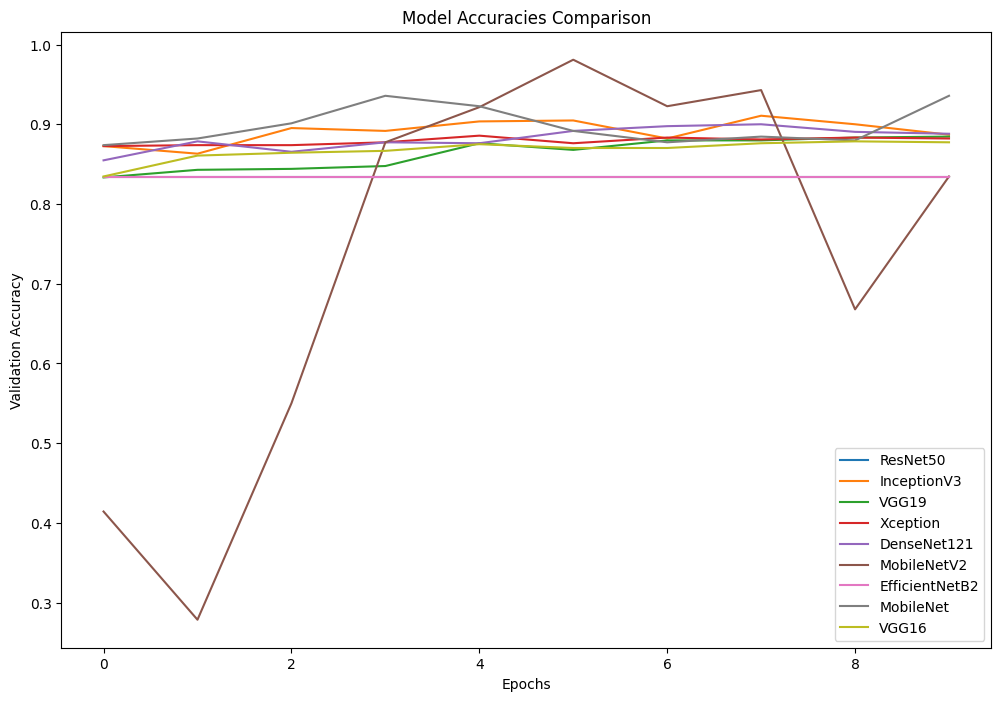

In [22]:
# Plotting accuracies
plt.figure(figsize=(12, 8))
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50')
plt.plot(inception_history.history['val_accuracy'], label='InceptionV3')
plt.plot(vgg19_history.history['val_accuracy'], label='VGG19')
plt.plot(xception_history.history['val_accuracy'], label='Xception')
plt.plot(densenet_history.history['val_accuracy'], label='DenseNet121')
plt.plot(mobilenetv2_history.history['val_accuracy'], label='MobileNetV2')
plt.plot(efficientnet_history.history['val_accuracy'], label='EfficientNetB2')

# Add MobileNet and VGG16
plt.plot(mobilenet_history.history['val_accuracy'], label='MobileNet')
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model Accuracies Comparison')
plt.legend()
plt.show()



42/42 [==============================] - 9s 185ms/step


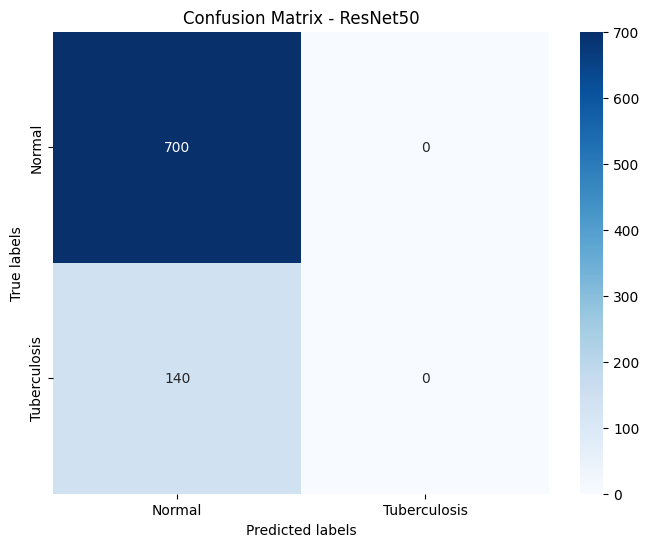

Accuracy of ResNet50: 0.8333333333333334
Classification Report of ResNet50:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       700
           1       0.00      0.00      0.00       140

    accuracy                           0.83       840
   macro avg       0.42      0.50      0.45       840
weighted avg       0.69      0.83      0.76       840





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 9s 197ms/step


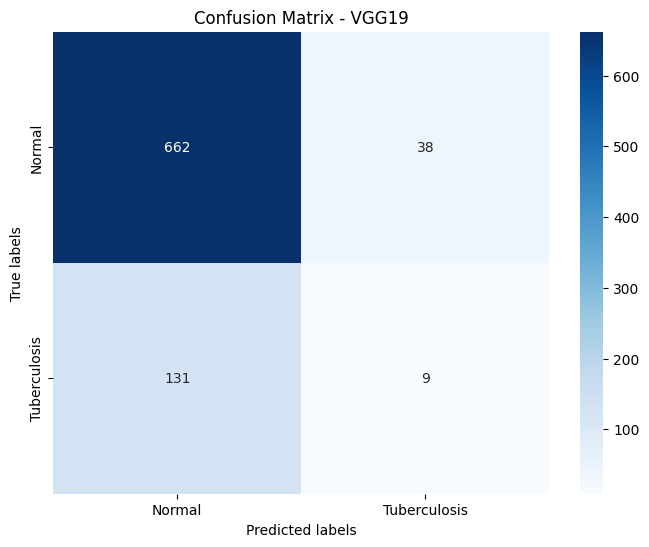

Accuracy of VGG19: 0.7988095238095239
Classification Report of VGG19:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       700
           1       0.19      0.06      0.10       140

    accuracy                           0.80       840
   macro avg       0.51      0.51      0.49       840
weighted avg       0.73      0.80      0.76       840



42/42 [==============================] - 18s 400ms/step


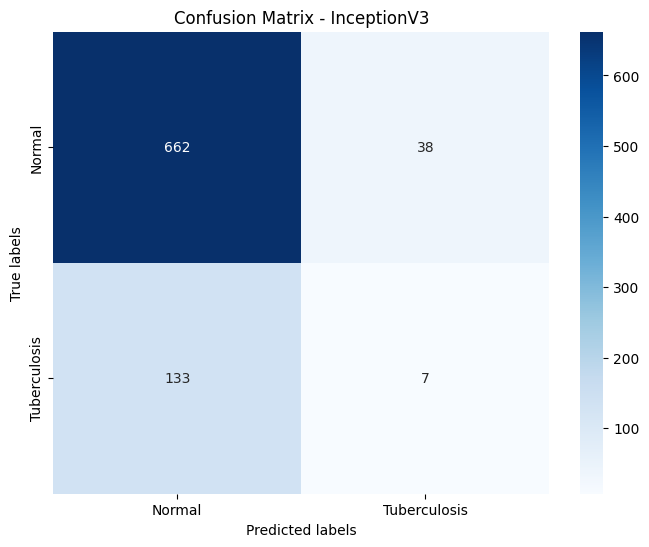

Accuracy of InceptionV3: 0.7964285714285714
Classification Report of InceptionV3:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       700
           1       0.16      0.05      0.08       140

    accuracy                           0.80       840
   macro avg       0.49      0.50      0.48       840
weighted avg       0.72      0.80      0.75       840



42/42 [==============================] - 10s 214ms/step


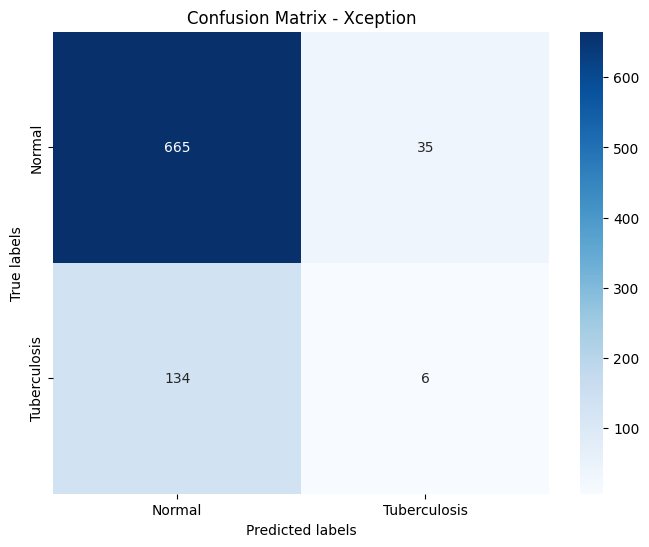

Accuracy of Xception: 0.7988095238095239
Classification Report of Xception:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       700
           1       0.15      0.04      0.07       140

    accuracy                           0.80       840
   macro avg       0.49      0.50      0.48       840
weighted avg       0.72      0.80      0.75       840



42/42 [==============================] - 10s 192ms/step


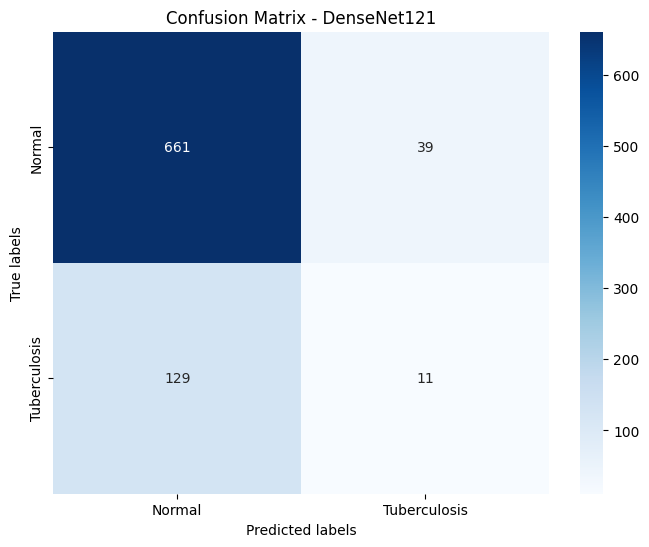

Accuracy of DenseNet121: 0.8
Classification Report of DenseNet121:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       700
           1       0.22      0.08      0.12       140

    accuracy                           0.80       840
   macro avg       0.53      0.51      0.50       840
weighted avg       0.73      0.80      0.76       840



42/42 [==============================] - 8s 169ms/step


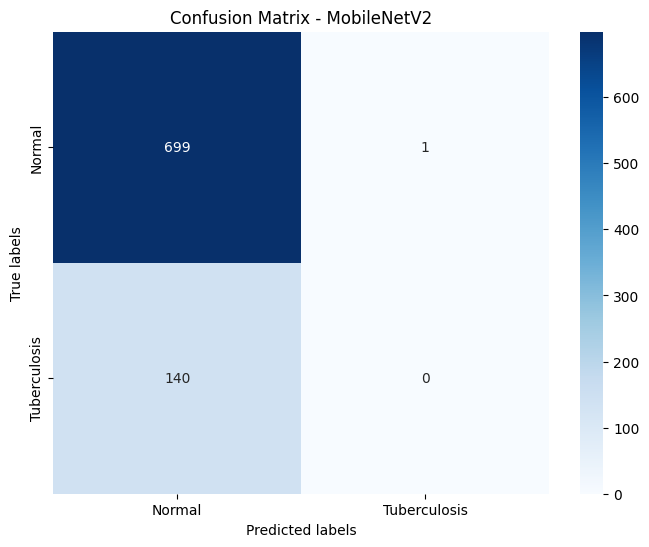

Accuracy of MobileNetV2: 0.8321428571428572
Classification Report of MobileNetV2:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       700
           1       0.00      0.00      0.00       140

    accuracy                           0.83       840
   macro avg       0.42      0.50      0.45       840
weighted avg       0.69      0.83      0.76       840



42/42 [==============================] - 10s 177ms/step


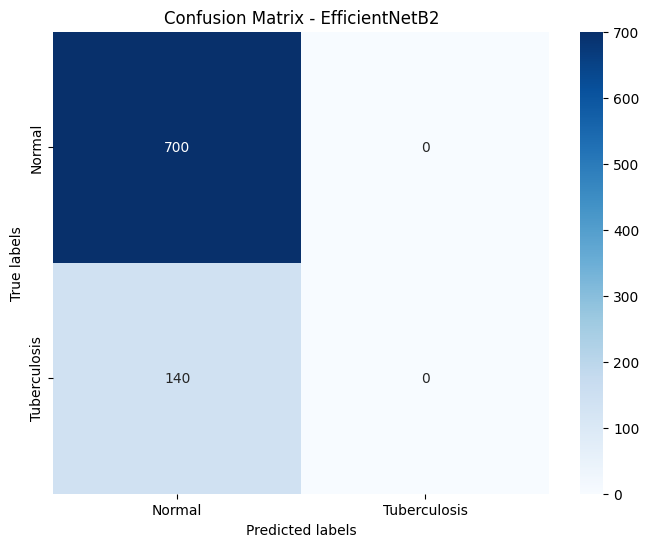

Accuracy of EfficientNetB2: 0.8333333333333334
Classification Report of EfficientNetB2:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       700
           1       0.00      0.00      0.00       140

    accuracy                           0.83       840
   macro avg       0.42      0.50      0.45       840
weighted avg       0.69      0.83      0.76       840





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 9s 195ms/step


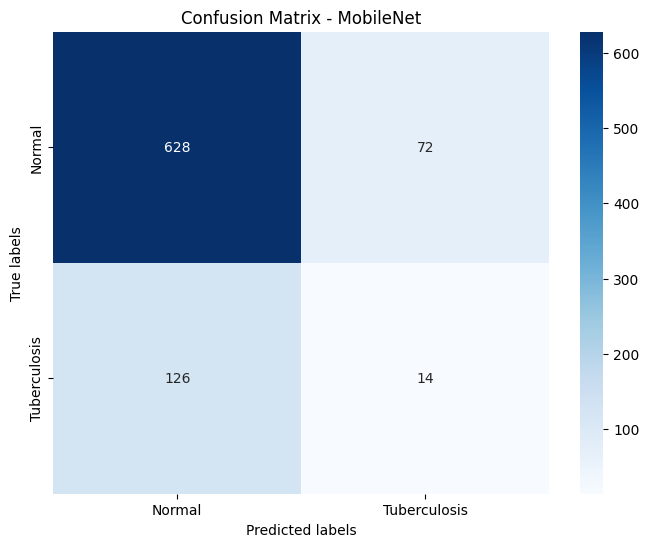

Accuracy of MobileNet: 0.7642857142857142
Classification Report of MobileNet:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       700
           1       0.16      0.10      0.12       140

    accuracy                           0.76       840
   macro avg       0.50      0.50      0.49       840
weighted avg       0.72      0.76      0.74       840



42/42 [==============================] - 9s 202ms/step


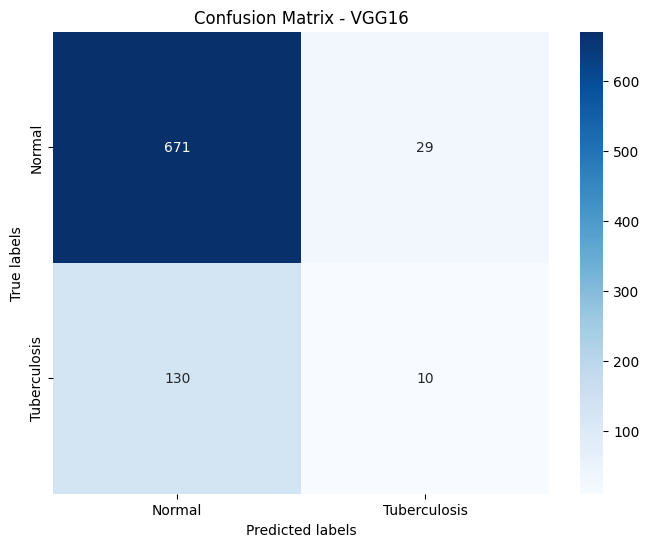

Accuracy of VGG16: 0.8107142857142857
Classification Report of VGG16:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89       700
           1       0.26      0.07      0.11       140

    accuracy                           0.81       840
   macro avg       0.55      0.52      0.50       840
weighted avg       0.74      0.81      0.76       840





In [23]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def print_model_results(model, val_data, model_name):
    prediction = model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=1)
    prediction = (prediction > 0.5)
    pred2 = [i[1] for i in prediction]
    cm = confusion_matrix(val_data.classes, pred2)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    accuracy = accuracy_score(val_data.classes, pred2)
    print(f"Accuracy of {model_name}: {accuracy}")
    print(f"Classification Report of {model_name}:\n{classification_report(val_data.classes, pred2)}\n\n")

# Example usage for all 10 models

print_model_results(resnet_model, val_data, "ResNet50")
print_model_results(vgg19_model, val_data, "VGG19")
print_model_results(inception_model, val_data, "InceptionV3")
print_model_results(xception_model, val_data, "Xception")
print_model_results(densenet_model, val_data, "DenseNet121")
print_model_results(mobilenetv2_model, val_data, "MobileNetV2")
print_model_results(efficientnet_model, val_data, "EfficientNetB2")

print_model_results(mobilenet_model, val_data, "MobileNet")
print_model_results(vgg16_model, val_data, "VGG16")



In [25]:
# Assuming models are already defined and trained
models = {
    'ResNet50': resnet_model,
    'VGG19': vgg19_model,
    'InceptionV3': inception_model,
    'Xception': xception_model,
    'DenseNet121': densenet_model,
    'MobileNetV2':mobilenetv2_model,
    'EfficientNetB2': efficientnet_model,
    'MobileNet': mobilenet_model,
    'VGG16': vgg16_model
}


accuracies = {}

for name, model in models.items():
    prediction = model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=1)
    prediction = (prediction > 0.5)
    pred2 = [i[1] for i in prediction]
    accuracy = accuracy_score(val_data.classes, pred2)
    accuracies[name] = accuracy
    print(f"Accuracy of {name}: {accuracy}")

# Print the accuracies for all models
print(accuracies)


42/42 [==============================] - 8s 201ms/step
Accuracy of ResNet50: 0.8333333333333334
42/42 [==============================] - 8s 188ms/step
Accuracy of VGG19: 0.805952380952381
42/42 [==============================] - 9s 203ms/step
Accuracy of InceptionV3: 0.7916666666666666
42/42 [==============================] - 8s 190ms/step
Accuracy of Xception: 0.7964285714285714
42/42 [==============================] - 8s 180ms/step
Accuracy of DenseNet121: 0.8023809523809524
42/42 [==============================] - 8s 188ms/step
Accuracy of MobileNetV2: 0.8321428571428572
42/42 [==============================] - 10s 227ms/step
Accuracy of EfficientNetB2: 0.8333333333333334
42/42 [==============================] - 10s 228ms/step
Accuracy of MobileNet: 0.7714285714285715
42/42 [==============================] - 8s 188ms/step
Accuracy of VGG16: 0.8035714285714286
{'ResNet50': 0.8333333333333334, 'VGG19': 0.805952380952381, 'InceptionV3': 0.7916666666666666, 'Xception': 0.796428571428571

42/42 [==============================] - 9s 215ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 7s 173ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


42/42 [==============================] - 8s 193ms/step


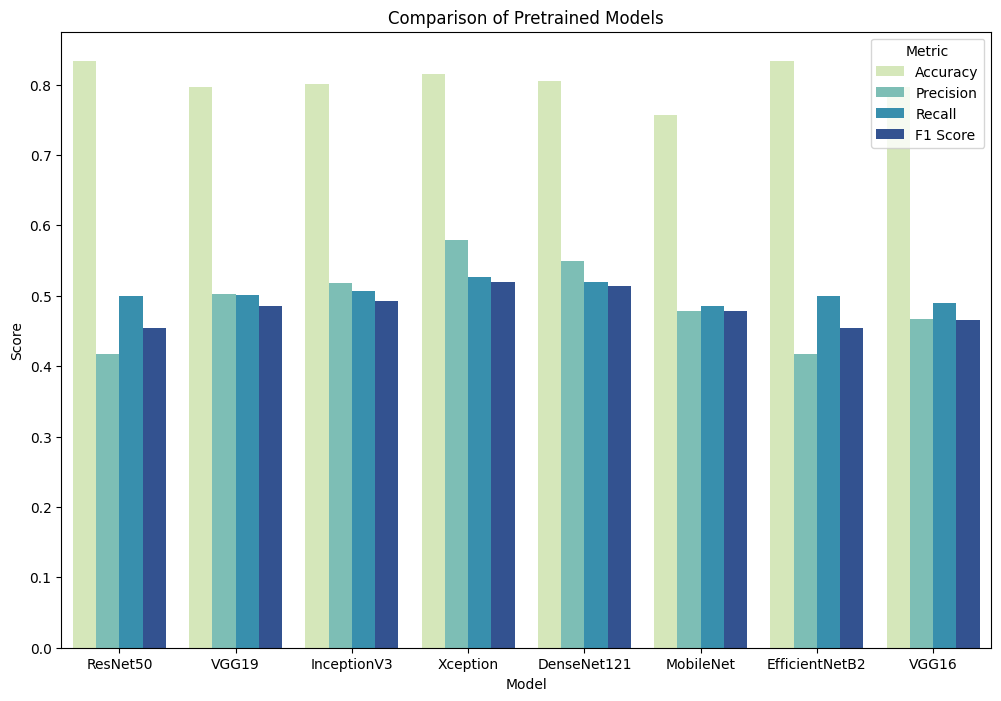

In [28]:
# Assuming models are already defined and trained
models = {
    'ResNet50': resnet_model,
    'VGG19': vgg19_model,
    'InceptionV3': inception_model,
    'Xception': xception_model,
    'DenseNet121': densenet_model,
    'MobileNet': mobilenetv2_model,
    'EfficientNetB2': efficientnet_model,
    'MobileNet': mobilenet_model,
    'VGG16': vgg16_model
}


model_results = []

for name, model in models.items():
    # Make predictions
    prediction = model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=1)
    prediction = (prediction > 0.5)
    pred2 = [i[1] for i in prediction]

    # Calculate accuracy score
    accuracy = accuracy_score(val_data.classes, pred2)

    # Create classification report
    classification_report_data = classification_report(val_data.classes, pred2, output_dict=True)
    precision = classification_report_data['macro avg']['precision']
    recall = classification_report_data['macro avg']['recall']
    f1_score = classification_report_data['macro avg']['f1-score']

    # Append results to model_results list
    model_results.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score})

# Create a DataFrame from model_results
model_results_df = pd.DataFrame(model_results)

# Melt the DataFrame to 'long' format for visualization
model_results_melted = pd.melt(model_results_df, id_vars=['Model'], var_name='Metric', value_name='Score')

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=model_results_melted, x='Model', y='Score', hue='Metric', palette='YlGnBu')
plt.title('Comparison of Pretrained Models')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()


In [32]:

from keras.applications import (ResNet50, VGG19, InceptionV3, Xception,
                                 DenseNet121, EfficientNetB2,
                                 VGG16, MobileNet, MobileNetV2)

# Define a dictionary to map model names to their respective classes
model_classes = {
    'ResNet50': ResNet50,
    'VGG19': VGG19,
    'InceptionV3': InceptionV3,
    'Xception': Xception,
    'DenseNet121': DenseNet121,
    'MobileNet': MobileNetV2,  # Fixed to use MobileNetV2 instead of MobileNet
    'EfficientNetB2': EfficientNetB2,
    'VGG16': VGG16
}

# Create and print summaries for each model
for model_name, model_class in model_classes.items():
    model = model_class()
    print(f"\n{model_name} Summary:")
    model.summary()


102967424/102967424 [==============================] - 5s 0us/step

ResNet50 Summary:
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_14[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on) 